## Задача
Построить классификатор изображений рукописного ввода на базе MNIST.
Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.
Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

## Загружаем исходные данные

In [2]:
train = np.loadtxt('D:\\ml\\CV\\train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('D:\\ml\\CV\\test.csv', delimiter=',', skiprows=1)

In [3]:
train_label = train[:, 0]
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

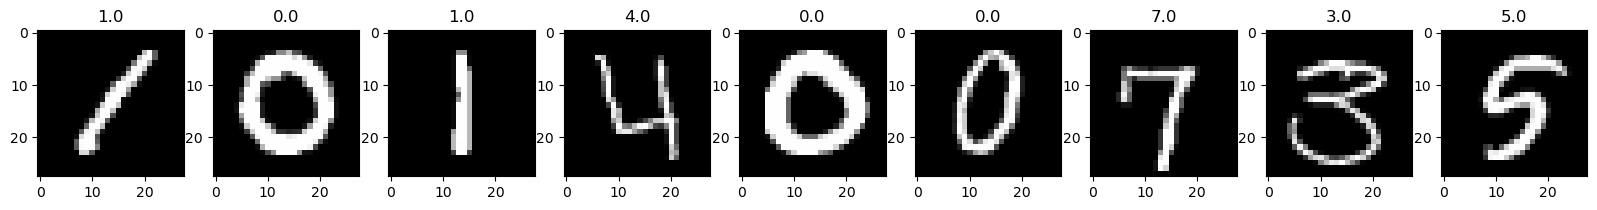

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:9], 1):
    subplot = fig.add_subplot(1, 9, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [5]:
train.shape, train_label.shape, test.shape

((42000, 785), (42000,), (28000, 784))

## Обучение модели на основе гистограммы градиентов (HOG)

Вычисляем X и Y составляющие градиента с помощью оператора Собеля.

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

Вычисляем угол и длину вектора градиента.

In [7]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

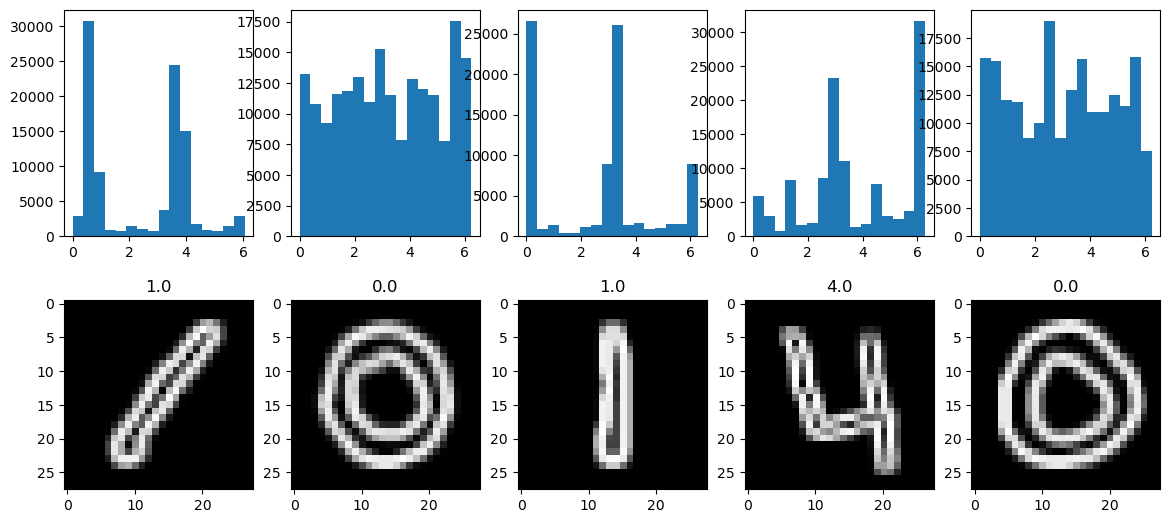

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

Вычисляем гистограммы градиентов с учетом длины вектора градиента.

In [9]:
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

Нормируем вектор гистограммы.

In [10]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

Обучение модели на основе train данных.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_hist, train_label, test_size=0.3, random_state=42)

In [12]:
model = SVC(random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [13]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.44      0.46      0.45      1200
         1.0       0.97      0.95      0.96      1389
         2.0       0.51      0.44      0.48      1294
         3.0       0.66      0.70      0.68      1355
         4.0       0.70      0.71      0.70      1222
         5.0       0.62      0.66      0.64      1085
         6.0       0.51      0.46      0.48      1256
         7.0       0.87      0.79      0.83      1359
         8.0       0.52      0.59      0.55      1209
         9.0       0.66      0.70      0.68      1231

    accuracy                           0.65     12600
   macro avg       0.65      0.65      0.64     12600
weighted avg       0.65      0.65      0.65     12600



Предсказание метки на основе test данных.

In [14]:
pred_test = model.predict(test_hist)

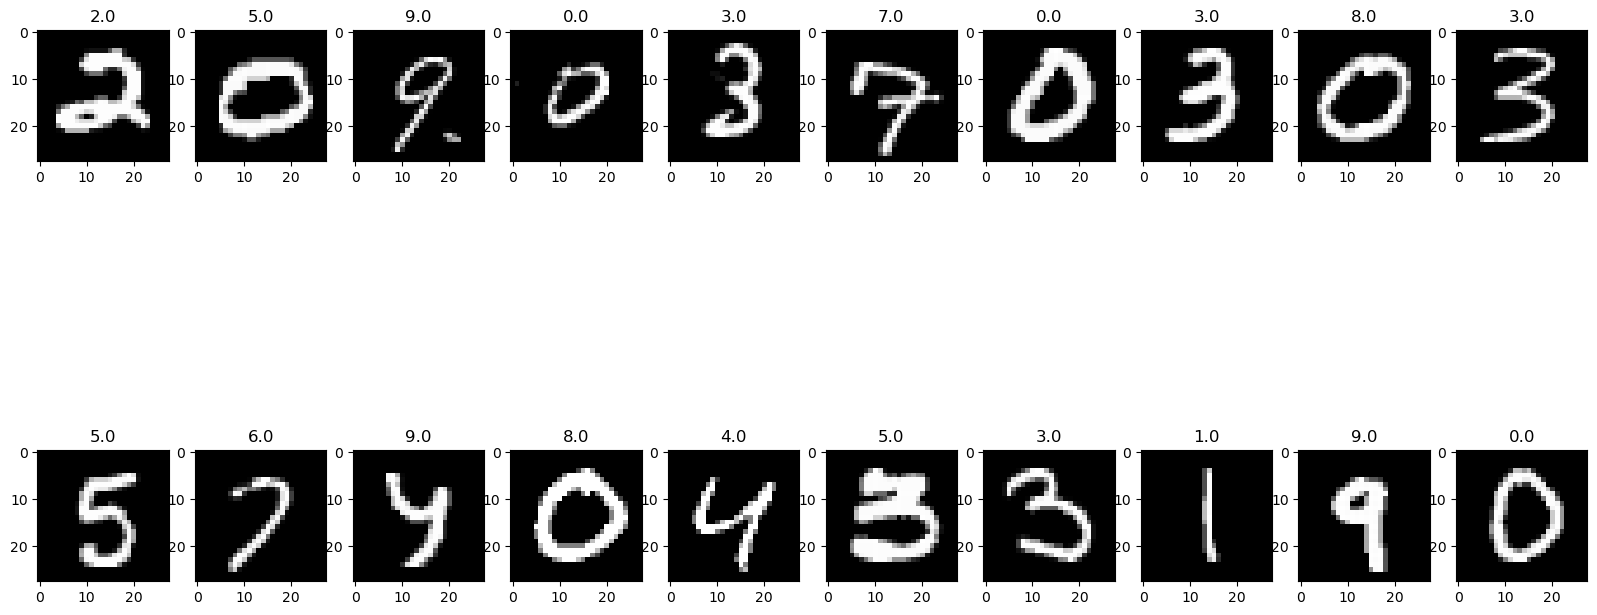

In [15]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

**Вывод:** Для классификатора построенного на признаках, полученных в результате предобработки изображений с помощью гистограммы градиентов (HOG) была полученна accuracy 0.65. Для test данных была построена визуализация с полученными метками.

Выберем другую модель - RandomForest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators = 150, min_samples_leaf =1, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [17]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.42      0.41      0.41      1200
         1.0       0.97      0.96      0.96      1389
         2.0       0.50      0.45      0.47      1294
         3.0       0.65      0.68      0.67      1355
         4.0       0.70      0.68      0.69      1222
         5.0       0.63      0.65      0.64      1085
         6.0       0.48      0.45      0.46      1256
         7.0       0.86      0.78      0.82      1359
         8.0       0.49      0.58      0.53      1209
         9.0       0.63      0.70      0.66      1231

    accuracy                           0.64     12600
   macro avg       0.63      0.63      0.63     12600
weighted avg       0.64      0.64      0.64     12600



Вывод: C использованием RandomForestClassifier были получены практически такие же результаты, accuracy 0.64. Такая точночть не может нас радовать

### Обучение модели на основе результата PCA преобразования.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train[:, 1:], train_label, test_size=0.3, random_state=42)

In [19]:
cov_matrix = np.matmul(X_train.T, X_train)
cov_matrix.shape

(784, 784)

In [20]:
U, S, _ = np.linalg.svd(cov_matrix)
S_cumsum = np.cumsum(S) / np.sum(S)

Text(0.5, 1.0, 'График совокупной дисперсии')

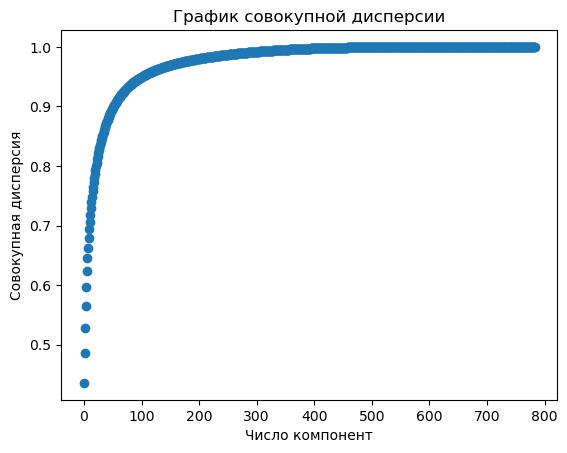

In [21]:
plt.plot(S_cumsum, 'o')
plt.xlabel('Число компонент')
plt.ylabel('Совокупная дисперсия')
plt.title('График совокупной дисперсии')

подберём оптимальное кол-во компонент 

In [22]:
S_thr = 0.9
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=52 S=0.901


Оптимальным оказался порог 0.9 при n_comp=52.

Обучим модель, используя PCA преобразование для полученного числа компонент.

In [23]:
model = make_pipeline(PCA(n_components=52,
                              copy = True,
                              whiten = False,
                              svd_solver = 'auto',
                              tol = 0.0, 
                              iterated_power = 'auto',
                              random_state = 42),
                          StandardScaler(), 
                          SVC(random_state=21))
model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=52, random_state=42)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=21))])

In [24]:
pred = model.predict(X_test)
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1200
         1.0       0.99      0.99      0.99      1389
         2.0       0.98      0.97      0.97      1294
         3.0       0.98      0.96      0.97      1355
         4.0       0.97      0.98      0.97      1222
         5.0       0.97      0.98      0.98      1085
         6.0       0.98      0.98      0.98      1256
         7.0       0.98      0.98      0.98      1359
         8.0       0.96      0.98      0.97      1209
         9.0       0.98      0.96      0.97      1231

    accuracy                           0.98     12600
   macro avg       0.98      0.98      0.98     12600
weighted avg       0.98      0.98      0.98     12600



In [25]:
print(accuracy_score(y_test, pred))

0.9776984126984127


In [26]:
pred_test = model.predict(test)

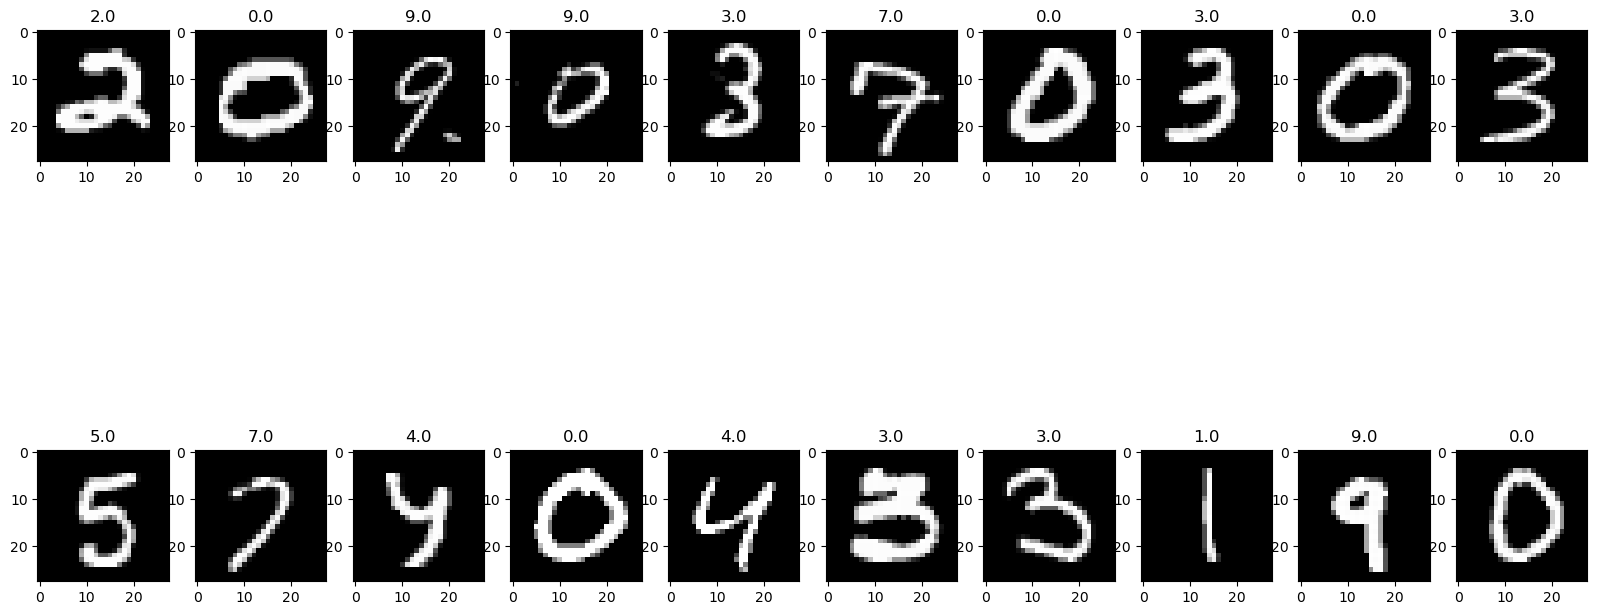

In [27]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % pred_test[i - 1])

**Вывод:** Для классификатора построенного на признаках, полученных на результате PCA преобразования, была полученна accuracy **0.98**. Для test данных была построена визуализация с полученными метками.

### Готовим результат 

In [29]:
with open('result.csv', 'w') as res:
    res.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        res.write(f'{i},{int(p)}\n')

In [31]:
res = pd.read_csv('result.csv')
res.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


## Итог

С использованием классификаторов SVC, RandomForestClassifier  на основе признаков, полученных на основе обработки изображения с помощью гистограммы градиентов (HOG): получено accuracy 0.65, 0.64
С использованием PCA преобразования получено accuracy 0.98